In [1]:
# Run this code without any changes
# Basic imports

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils.vis_utils import plot_model
from keras import backend as K

from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from keras.layers import Reshape, Flatten, BatchNormalization, Activation

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# **Step 1: Load the data using Option 1 or Option 2 below. (Start with Option 1, then move onto Step 2)**
### **Option 1: Use MNIST digits (Start here first**

In [2]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
#original_dim = image_size * image_size
#x_train = np.reshape(x_train, [-1, original_dim])
#x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
input_shape = x_train[0].shape
x_train = np.reshape(x_train, x_train.shape+(1,))
x_test = np.reshape(x_test, x_test.shape+(1,))

print("We loaded the MNIST dataset:")
print("input_shape:", input_shape)
print("x_train:", x_train.shape)
print("x_test:", x_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
We loaded the MNIST dataset:
input_shape: (28, 28)
x_train: (60000, 28, 28, 1)
x_test: (10000, 28, 28, 1)


(28, 28, 1) stats: 0.99607843 0.0 0.12882152


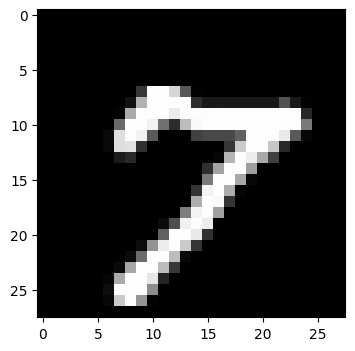

In [3]:
# Let's look at one sample:
x1 = x_test[9000] #looks at the 9000th sample
print(x1.shape, "stats:", np.max(x1), np.min(x1), np.mean(x1))

#Show it as an image:
plt.figure(figsize=(4,4))
plt.imshow(x1[:,:,0], cmap='gray', vmin=0.0, vmax=1.0)
plt.show()

# **Step 2: Now that you've loaded data (either MNIST or QuickDraw), do this to build the model:**
Ensure that you've chosen either the MNIST or QuickDraw dataset above, and the dataset you want is now loaded into x_train and x_test.
This code builds a model using a standard convolutional autoencoder architecture:
Image -> Encoder -> latent vector representation -> Decoder -> Reconstruction

In [4]:
# network parameters
input_shape = (28, 28, 1)
latent_dim = 32 #you might play with changing this

# VAE model = encoder + decoder

# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')

#kernels = 26 #you could change this too
kernels = 20

x = Conv2D(kernels, (3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2), padding='same')(x)
x = Conv2D(int(kernels/2), (3), activation='relu', padding='same')(x)
x = MaxPooling2D((2), padding='same')(x)
x = Conv2D(int(kernels/4), (3), activation='relu', padding='same')(x)
x = MaxPooling2D((2), padding='same')(x)
intermediate_conv_shape = x.get_shape()
x = Flatten()(x)

# optionally BN?
x = BatchNormalization()(x)
x = Activation("relu")(x)

_,n,m,o = intermediate_conv_shape # (None, 4, 4, 6) # 96
intermediate_dim = n*m*o

#some fully connected layers in the middle?
#x = Dense(intermediate_dim, activation='relu')(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)

# optionally BN?
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Reshape((n,m,o))(x)
x = Conv2D(int(kernels/4), (3), activation='relu', padding='same')(x)
x = UpSampling2D((2))(x)
x = Conv2D(int(kernels/2), (3), activation='relu', padding='same')(x)
x = UpSampling2D((2))(x)
x = Conv2D(int(kernels), (3), activation='relu')(x)
x = UpSampling2D((2))(x)
outputs = Conv2D(1, (3), activation='sigmoid', padding='same')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [5]:

encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 20)   200         ['encoder_input[0][0]']          
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 14, 14, 20)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 10)   1810        ['max_pooling2d[0][0]']          
                                                                                            

In [6]:
models = (encoder, decoder)
data = (x_test, y_test)

args_mse = False
# VAE loss = mse_loss or xent_loss + kl_loss
if args_mse:
    reconstruction_loss = mse(inputs, outputs)
else:
    reconstruction_loss = binary_crossentropy(inputs, outputs)

m = input_shape[0]*input_shape[1]
reconstruction_loss *= m # 28x28 values
reconstruction_loss = K.sum(reconstruction_loss)
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae_loss /= m
vae_loss /= m
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           [(None, 32),         7969        ['encoder_input[0][0]']          
                                 (None, 32),                                                      
                                 (None, 32)]                                                      
                                                                                                  
 decoder (Functional)           (None, 28, 28, 1)    5651        ['encoder[0][2]']                
                                                                                            

In [7]:
batch_size = 128
epochs = 10

#history = vae.fit(x_train[0:1000], epochs=epochs, shuffle=True, batch_size=batch_size, validation_data=(x_test, None))
history = vae.fit(x_train, epochs=epochs, shuffle=True, batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/10
469/469 [==============================] - 106s 221ms/step - loss: 33.1866 - val_loss: 22.3083
Epoch 2/10
469/469 [==============================] - 97s 207ms/step - loss: 20.0303 - val_loss: 18.2007
Epoch 3/10
469/469 [==============================] - 96s 204ms/step - loss: 17.6583 - val_loss: 16.1444
Epoch 4/10
469/469 [==============================] - 94s 200ms/step - loss: 16.4001 - val_loss: 15.2905
Epoch 5/10
469/469 [==============================] - 93s 199ms/step - loss: 15.6613 - val_loss: 14.7259
Epoch 6/10
469/469 [==============================] - 95s 202ms/step - loss: 15.1425 - val_loss: 14.2909
Epoch 7/10
469/469 [==============================] - 94s 201ms/step - loss: 14.7632 - val_loss: 13.9048
Epoch 8/10
469/469 [==============================] - 96s 204ms/step - loss: 14.4351 - val_loss: 13.7731
Epoch 9/10
469/469 [==============================] - 93s 199ms/step - loss: 14.2180 - val_loss: 13.4558
Epoch 10/10
469/469 [==============================] -

Plot:


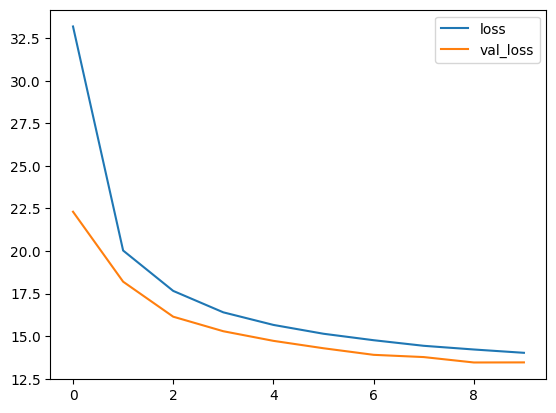

In [8]:
# How did we do?
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_array = list(range(epochs))
plt.plot(epochs_array, loss, label="loss")
plt.plot(epochs_array, val_loss, label="val_loss")
plt.legend()

print("Plot:")

In [9]:
import json

def save_model(model, name):
    model_json = model.to_json()
    with open(name+".json", "w") as json_file:
        json.dump(model_json, json_file)

    model.save_weights(name+".h5")

#you might want to give your model an understandable filename
save_model(encoder,'encoder_mnist')
save_model(decoder,'decoder_mnist')
#save_model(encoder,'encoder_draw_10ep')
#save_model(decoder,'decoder_draw_10ep')

### **Now let's use it!**

In [10]:
# We can carry these files (*.h5, *.json) somewhere else ...
from keras.models import load_model
from keras.models import model_from_json
import json
def my_load_model(name):
    with open(name+'.json','r') as f:
        model_json = json.load(f)

    model = model_from_json(model_json)
    model.load_weights(name+'.h5')
    return model

#Use same filename as above here
decoder = my_load_model('decoder_mnist')
encoder = my_load_model('encoder_mnist')
#decoder = my_load_model('decoder_draw_10ep')
#encoder = my_load_model('encoder_draw_10ep')

(28, 28, 1)
1.0 0.0 0.147504


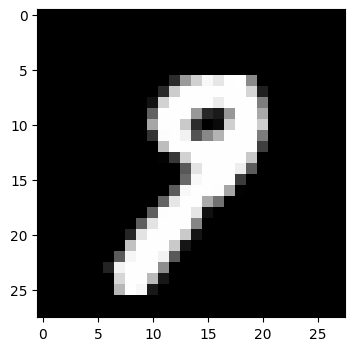

In [11]:
# Encoded image:

x1 = x_test[73] # number 73 picked for no reason at all
print(x1.shape)
print(np.max(x1), np.min(x1), np.mean(x1))

img = x1[:,:,0]

plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray', vmin=0.0, vmax=1.0)
plt.show()

1/1 [==============================] - 0s 156ms/step
(1, 32)
8.005855 -6.1618967 -0.032577872


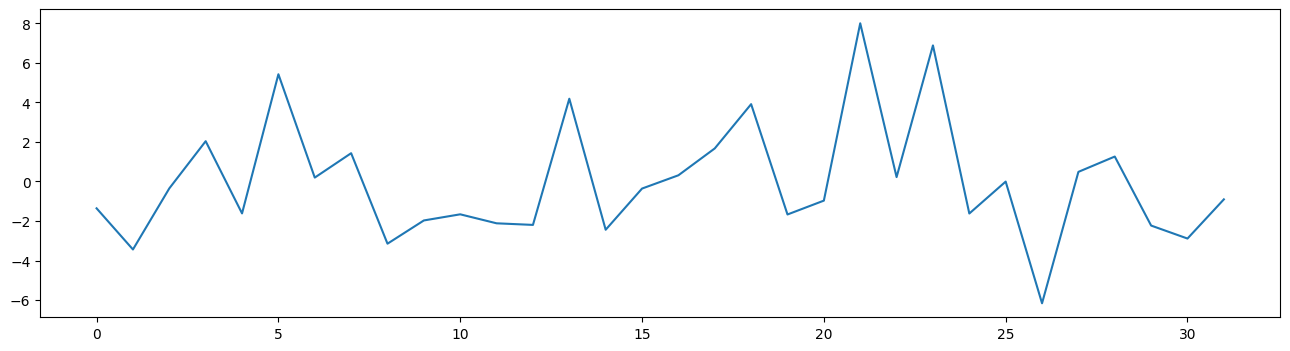

In [12]:
# Latent vector:

x1_arr = np.asarray([x1])
z, z_mean, z_log_var = encoder.predict(x1_arr)
print(z.shape)
print(np.max(z), np.min(z), np.mean(z))

plt.figure(figsize=(16,4))
plt.plot(z[0])
plt.show()

#Plotting is not particularly informative here, it's just a set of 32 numbers, but why not?

1/1 [==============================] - 0s 89ms/step
(1, 28, 28, 1)


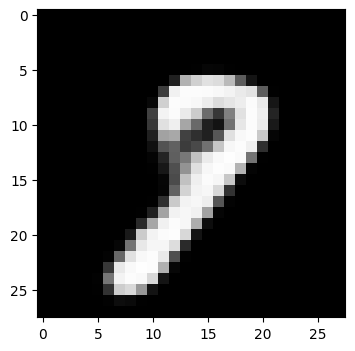

In [13]:
# Reconstructed image

y1 = decoder.predict(z)
print(y1.shape)
y1 = y1[0]

img = y1[:,:,0]

plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray', vmin=0.0, vmax=1.0)
plt.show()

### kernal = 46

In [17]:
# network parameters
input_shape = (28, 28, 1)
latent_dim = 32 #you might play with changing this

# VAE model = encoder + decoder

# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')

#kernels = 26 #you could change this too
kernels = 46

x = Conv2D(kernels, (3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2), padding='same')(x)
x = Conv2D(int(kernels/2), (3), activation='relu', padding='same')(x)
x = MaxPooling2D((2), padding='same')(x)
x = Conv2D(int(kernels/4), (3), activation='relu', padding='same')(x)
x = MaxPooling2D((2), padding='same')(x)
intermediate_conv_shape = x.get_shape()
x = Flatten()(x)

# optionally BN?
x = BatchNormalization()(x)
x = Activation("relu")(x)

_,n,m,o = intermediate_conv_shape # (None, 4, 4, 6) # 96
intermediate_dim = n*m*o

#some fully connected layers in the middle?
#x = Dense(intermediate_dim, activation='relu')(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)

# optionally BN?
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Reshape((n,m,o))(x)
x = Conv2D(int(kernels/4), (3), activation='relu', padding='same')(x)
x = UpSampling2D((2))(x)
x = Conv2D(int(kernels/2), (3), activation='relu', padding='same')(x)
x = UpSampling2D((2))(x)
x = Conv2D(int(kernels), (3), activation='relu')(x)
x = UpSampling2D((2))(x)
outputs = Conv2D(1, (3), activation='sigmoid', padding='same')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [18]:

encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_21 (Conv2D)             (None, 28, 28, 46)   460         ['encoder_input[0][0]']          
                                                                                                  
 max_pooling2d_9 (MaxPooling2D)  (None, 14, 14, 46)  0           ['conv2d_21[0][0]']              
                                                                                                  
 conv2d_22 (Conv2D)             (None, 14, 14, 23)   9545        ['max_pooling2d_9[0][0]']        
                                                                                            

In [19]:
models = (encoder, decoder)
data = (x_test, y_test)

args_mse = False
# VAE loss = mse_loss or xent_loss + kl_loss
if args_mse:
    reconstruction_loss = mse(inputs, outputs)
else:
    reconstruction_loss = binary_crossentropy(inputs, outputs)

m = input_shape[0]*input_shape[1]
reconstruction_loss *= m # 28x28 values
reconstruction_loss = K.sum(reconstruction_loss)
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae_loss /= m
vae_loss /= m
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           [(None, 32),         24325       ['encoder_input[0][0]']          
                                 (None, 32),                                                      
                                 (None, 32)]                                                      
                                                                                                  
 decoder (Functional)           (None, 28, 28, 1)    19895       ['encoder[0][2]']                
                                                                                            

In [20]:
batch_size = 128
epochs = 10

#history = vae.fit(x_train[0:1000], epochs=epochs, shuffle=True, batch_size=batch_size, validation_data=(x_test, None))
history = vae.fit(x_train, epochs=epochs, shuffle=True, batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/10
469/469 [==============================] - 195s 410ms/step - loss: 26.2897 - val_loss: 19.6866
Epoch 2/10
469/469 [==============================] - 183s 391ms/step - loss: 16.1572 - val_loss: 15.0589
Epoch 3/10
469/469 [==============================] - 185s 395ms/step - loss: 14.4338 - val_loss: 13.7820
Epoch 4/10
469/469 [==============================] - 184s 393ms/step - loss: 13.6092 - val_loss: 14.1847
Epoch 5/10
469/469 [==============================] - 184s 392ms/step - loss: 13.1111 - val_loss: 12.2661
Epoch 6/10
469/469 [==============================] - 185s 395ms/step - loss: 12.6638 - val_loss: 12.0295
Epoch 7/10
469/469 [==============================] - 189s 404ms/step - loss: 12.4292 - val_loss: 12.0832
Epoch 8/10
469/469 [==============================] - 185s 395ms/step - loss: 12.2199 - val_loss: 11.7889
Epoch 9/10
469/469 [==============================] - 184s 393ms/step - loss: 11.9915 - val_loss: 11.3967
Epoch 10/10
469/469 [=========================

Plot:


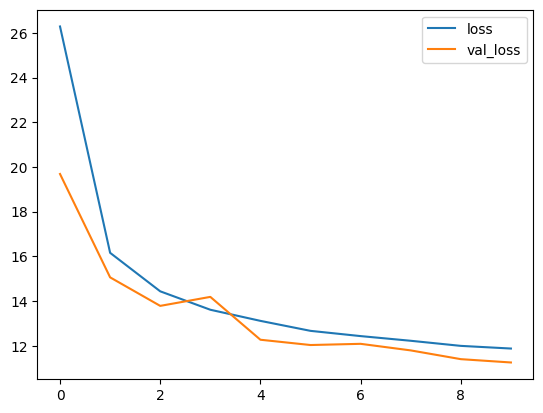

In [21]:
# How did we do?
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_array = list(range(epochs))
plt.plot(epochs_array, loss, label="loss")
plt.plot(epochs_array, val_loss, label="val_loss")
plt.legend()

print("Plot:")

In [22]:

import json

def save_model(model, name):
    model_json = model.to_json()
    with open(name+".json", "w") as json_file:
        json.dump(model_json, json_file)

    model.save_weights(name+".h5")

#you might want to give your model an understandable filename
save_model(encoder,'encoder_mnist')
save_model(decoder,'decoder_mnist')
#save_model(encoder,'encoder_draw_10ep')
#save_model(decoder,'decoder_draw_10ep')

In [23]:
# We can carry these files (*.h5, *.json) somewhere else ...
from keras.models import load_model
from keras.models import model_from_json
import json
def my_load_model(name):
    with open(name+'.json','r') as f:
        model_json = json.load(f)

    model = model_from_json(model_json)
    model.load_weights(name+'.h5')
    return model

#Use same filename as above here
decoder = my_load_model('decoder_mnist')
encoder = my_load_model('encoder_mnist')
#decoder = my_load_model('decoder_draw_10ep')
#encoder = my_load_model('encoder_draw_10ep')

## inspect details

(28, 28, 1)
1.0 0.0 0.147504


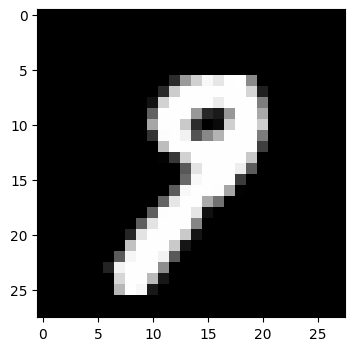

In [24]:
# Encoded image:

x1 = x_test[73] # number 73 picked for no reason at all
print(x1.shape)
print(np.max(x1), np.min(x1), np.mean(x1))

img = x1[:,:,0]

plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray', vmin=0.0, vmax=1.0)
plt.show()

1/1 [==============================] - 0s 97ms/step
(1, 32)
4.812164 -10.452898 -0.5184718


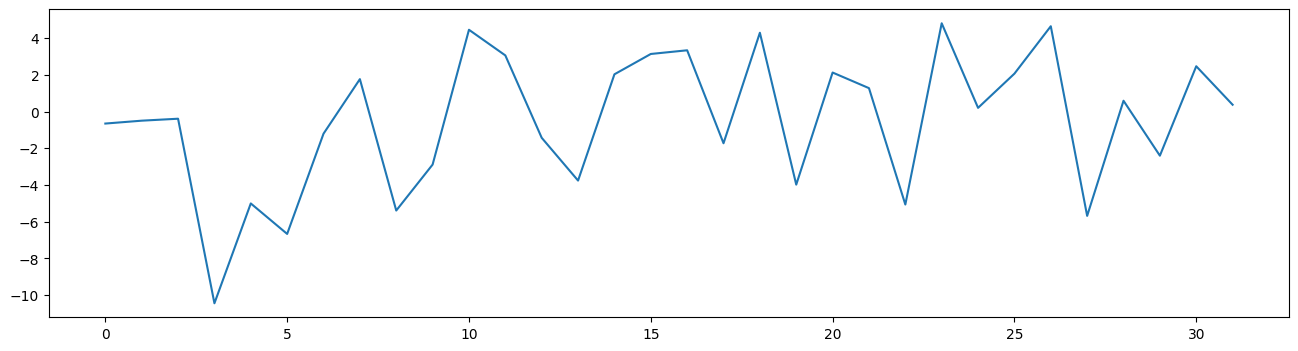

In [25]:
# Latent vector:

x1_arr = np.asarray([x1])
z, z_mean, z_log_var = encoder.predict(x1_arr)
print(z.shape)
print(np.max(z), np.min(z), np.mean(z))

plt.figure(figsize=(16,4))
plt.plot(z[0])
plt.show()

#Plotting is not particularly informative here, it's just a set of 32 numbers, but why not?

1/1 [==============================] - 0s 88ms/step
(1, 28, 28, 1)


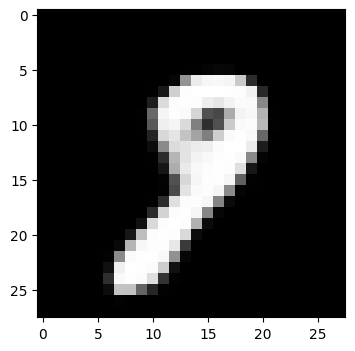

In [26]:
# Reconstructed image

y1 = decoder.predict(z)
print(y1.shape)
y1 = y1[0]

img = y1[:,:,0]

plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray', vmin=0.0, vmax=1.0)
plt.show()

### batch size =10
### kernel = 20

In [27]:
# network parameters
input_shape = (28, 28, 1)
latent_dim = 32 #you might play with changing this

# VAE model = encoder + decoder

# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')

kernels = 20 #you could change this too

x = Conv2D(kernels, (3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2), padding='same')(x)
x = Conv2D(int(kernels/2), (3), activation='relu', padding='same')(x)
x = MaxPooling2D((2), padding='same')(x)
x = Conv2D(int(kernels/4), (3), activation='relu', padding='same')(x)
x = MaxPooling2D((2), padding='same')(x)
intermediate_conv_shape = x.get_shape()
x = Flatten()(x)

# optionally BN?
x = BatchNormalization()(x)
x = Activation("relu")(x)

_,n,m,o = intermediate_conv_shape # (None, 4, 4, 6) # 96
intermediate_dim = n*m*o

#some fully connected layers in the middle?
#x = Dense(intermediate_dim, activation='relu')(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)

# optionally BN?
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Reshape((n,m,o))(x)
x = Conv2D(int(kernels/4), (3), activation='relu', padding='same')(x)
x = UpSampling2D((2))(x)
x = Conv2D(int(kernels/2), (3), activation='relu', padding='same')(x)
x = UpSampling2D((2))(x)
x = Conv2D(int(kernels), (3), activation='relu')(x)
x = UpSampling2D((2))(x)
outputs = Conv2D(1, (3), activation='sigmoid', padding='same')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [28]:

encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_28 (Conv2D)             (None, 28, 28, 20)   200         ['encoder_input[0][0]']          
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 14, 14, 20)  0           ['conv2d_28[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_29 (Conv2D)             (None, 14, 14, 10)   1810        ['max_pooling2d_12[0][0]'] 

In [29]:
models = (encoder, decoder)
data = (x_test, y_test)

args_mse = False
# VAE loss = mse_loss or xent_loss + kl_loss
if args_mse:
    reconstruction_loss = mse(inputs, outputs)
else:
    reconstruction_loss = binary_crossentropy(inputs, outputs)

m = input_shape[0]*input_shape[1]
reconstruction_loss *= m # 28x28 values
reconstruction_loss = K.sum(reconstruction_loss)
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae_loss /= m
vae_loss /= m
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           [(None, 32),         7969        ['encoder_input[0][0]']          
                                 (None, 32),                                                      
                                 (None, 32)]                                                      
                                                                                                  
 decoder (Functional)           (None, 28, 28, 1)    5651        ['encoder[0][2]']                
                                                                                            

In [30]:
batch_size = 10
epochs = 10

#history = vae.fit(x_train[0:1000], epochs=epochs, shuffle=True, batch_size=batch_size, validation_data=(x_test, None))
history = vae.fit(x_train, epochs=epochs, shuffle=True, batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/10
6000/6000 [==============================] - 141s 23ms/step - loss: 1.8525 - val_loss: 1.3334
Epoch 2/10
6000/6000 [==============================] - 125s 21ms/step - loss: 1.4059 - val_loss: 1.4789
Epoch 3/10
6000/6000 [==============================] - 126s 21ms/step - loss: 1.2913 - val_loss: 1.9775
Epoch 4/10
6000/6000 [==============================] - 125s 21ms/step - loss: 1.2372 - val_loss: 1.2900
Epoch 5/10
6000/6000 [==============================] - 126s 21ms/step - loss: 1.2101 - val_loss: 4.8075
Epoch 6/10
6000/6000 [==============================] - 127s 21ms/step - loss: 1.1890 - val_loss: 2.1399
Epoch 7/10
6000/6000 [==============================] - 126s 21ms/step - loss: 1.1755 - val_loss: 1.2051
Epoch 8/10
6000/6000 [==============================] - 127s 21ms/step - loss: 1.1660 - val_loss: 1.6205
Epoch 9/10
6000/6000 [==============================] - 127s 21ms/step - loss: 1.1586 - val_loss: 2.1512
Epoch 10/10
6000/6000 [==============================] 

Plot:


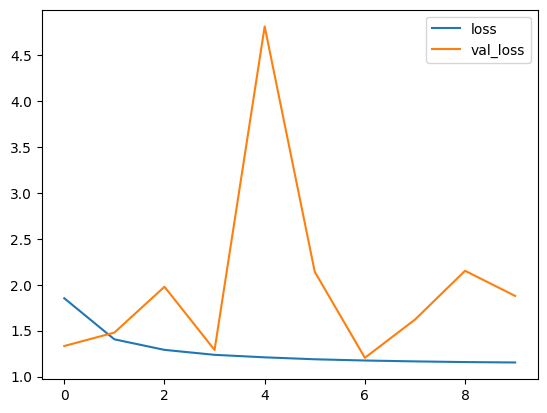

In [31]:

# How did we do?
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_array = list(range(epochs))
plt.plot(epochs_array, loss, label="loss")
plt.plot(epochs_array, val_loss, label="val_loss")
plt.legend()

print("Plot:")

In [32]:

import json

def save_model(model, name):
    model_json = model.to_json()
    with open(name+".json", "w") as json_file:
        json.dump(model_json, json_file)

    model.save_weights(name+".h5")

#you might want to give your model an understandable filename
save_model(encoder,'encoder_mnist')
save_model(decoder,'decoder_mnist')
#save_model(encoder,'encoder_draw_10ep')
#save_model(decoder,'decoder_draw_10ep')

In [33]:
# We can carry these files (*.h5, *.json) somewhere else ...
from keras.models import load_model
from keras.models import model_from_json
import json
def my_load_model(name):
    with open(name+'.json','r') as f:
        model_json = json.load(f)

    model = model_from_json(model_json)
    model.load_weights(name+'.h5')
    return model

#Use same filename as above here
decoder = my_load_model('decoder_mnist')
encoder = my_load_model('encoder_mnist')
#decoder = my_load_model('decoder_draw_10ep')
#encoder = my_load_model('encoder_draw_10ep')

(28, 28, 1)
1.0 0.0 0.147504


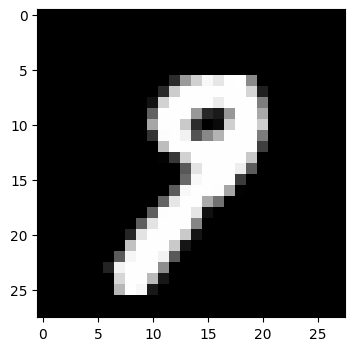

In [34]:
# Encoded image:

x1 = x_test[73] # number 73 picked for no reason at all
print(x1.shape)
print(np.max(x1), np.min(x1), np.mean(x1))

img = x1[:,:,0]

plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray', vmin=0.0, vmax=1.0)
plt.show()

1/1 [==============================] - 0s 98ms/step
(1, 32)
3.2240486 -3.5322094 -0.09212037


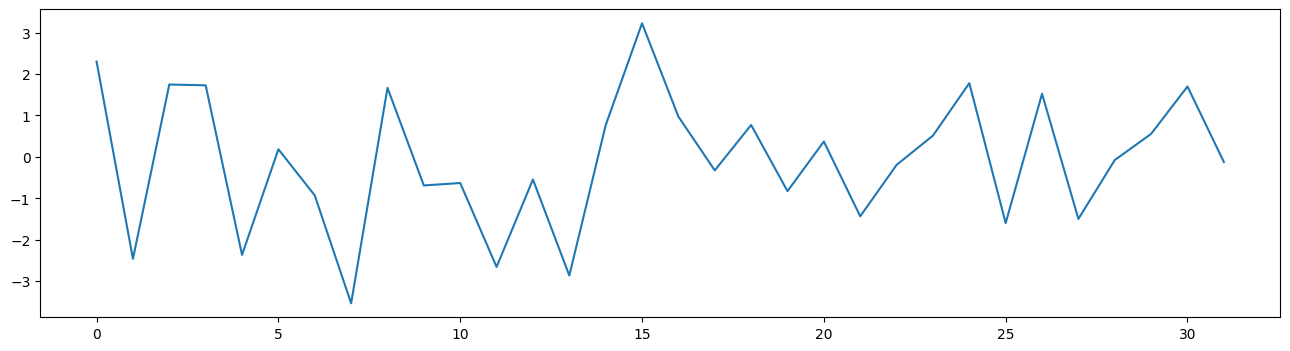

In [35]:
# Latent vector:

x1_arr = np.asarray([x1])
z, z_mean, z_log_var = encoder.predict(x1_arr)
print(z.shape)
print(np.max(z), np.min(z), np.mean(z))

plt.figure(figsize=(16,4))
plt.plot(z[0])
plt.show()

#Plotting is not particularly informative here, it's just a set of 32 numbers, but why not?

1/1 [==============================] - 0s 93ms/step
(1, 28, 28, 1)


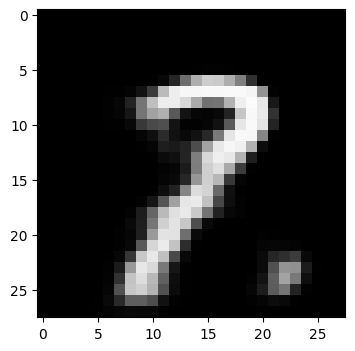

In [36]:
# Reconstructed image

y1 = decoder.predict(z)
print(y1.shape)
y1 = y1[0]

img = y1[:,:,0]

plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray', vmin=0.0, vmax=1.0)
plt.show()


# **Activities to do on your own**
1.(Easy) Try modifying the autoencoder or its training in at least one way that gives you a noticeable impact on the results. (e.g., change the optimiser, the number of kernels, the number of layers, the dimensionality of the latent vector, the activation function, etc.) How does this impact on the results? What changes did you try that did not impact the results noticably?

2.(More difficult) Try training this autoencoder on a new dataset. For instance, you might grab an existing image dataset from https://www.kaggle.com/datasets?tags=13207-Computer+Vision.


*   You will have to tweak the code above if your images are a different size other than 28x28 (it's unwise to use images that are significantly bigger than this, though, unless you are willing to wait a while for training!). For instance, the input_shape variable above specifies the input size.
*   Further, you'll need to tweak the code if you're using colour images, as this code works with grayscale (i.e., images are 28x28x1).
*   [This blog post](https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/) provides a good introduction to managing your own datasets

  *   Note that you can use target_size to specify the size of the image to read
*   If you want to do a batch resize/edit on images within a directory, you might find [tools like this one](https://github.com/dvschultz/dataset-tools) useful


3.(More difficult) Try building a version of Mario Klingemann's "X Degrees of Separation" for a dataset (could be MNIST or QuickDraw or something else). Write the code to select 5 (or some other number) of existing images that follow a smooth (as smooth as possible) path through latent space between two chosen images.